# Load the required Python libraries

In [1]:
import os
import numpy as np
import pandas as pd

import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode
import shutil
from PIL import Image  # To create gifs

from Mapfct import *     # Here is where we call the function.
from Crossfct import *   # Here is where we call the function.

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Chlorophyll change

## Load dataset into xArray

To get more precise results, we use the monthly data to fit so there could be more more data points.
Quirying huge amounts of data from the server occupys the program memory, and a repeat access always lead to a 'Write to read only'error, so we download them in year seperately and then combine them in one ncdata file finally. This is done in another notebook.

In [2]:
ds_bio_chl = xr.open_mfdataset("ds_bio_chl.nc")
ds_bio_chl

<xarray.Dataset>
Dimensions:    (time: 96, latitude: 723, longitude: 491)
Coordinates:
    zc         float64 ...
  * time       (time) datetime64[ns] 2010-12-31T14:00:00 ... 2018-11-30T14:00:00
  * latitude   (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude  (longitude) float64 142.2 142.2 142.2 142.3 ... 156.8 156.8 156.9
Data variables:
    Chl_a_sum  (time, latitude, longitude) float32 dask.array<chunksize=(96, 723, 491), meta=np.ndarray>
Attributes: (12/20)
    Conventions:                     CF-1.0
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    RunID:                           2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2021-09-08T01:59:05+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__GBR4_H2p0...
    ...                              ...
    paramfile:                       /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_C...
    paramhead:                       eReefs 4 km grid. SOURCE Catchments with...
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 BioGeoChemical 3....
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
ds = ds_bio_chl.Chl_a_sum

## Chlorophyll variation Linear fitting

Here we do the linear fitting between chlorophyll a and time index, and take the coefficients at every map points, to show the overall changes in chlorophyll a in the Great Barrier Reef. 

First, we replace the oringinal time coordanate with the time index(number of months),so it will be easier for calculation.


In [4]:
#replace with time index
timeIndex = [i+1 for i in range(len(ds.time))]
newDataArray = ds.assign_coords(time=timeIndex)
# newDataArray


After that, we use the Dataset.polyfit()function in xarray to do the linear fitting and return a summay results dataset. We use the variable "polyfit_coefficients" for the afterwards mapping and calculation,in which degree=1 points to the coefficient and degree=0 points to the constant of the fitting line.

In [5]:
# use the polyfit function to do linear fitting
res = newDataArray.polyfit(dim='time',deg=1)
res

<xarray.Dataset>
Dimensions:               (degree: 2, latitude: 723, longitude: 491)
Coordinates:
  * degree                (degree) int32 1 0
  * latitude              (latitude) float64 -28.7 -28.67 ... -7.066 -7.036
  * longitude             (longitude) float64 142.2 142.2 142.2 ... 156.8 156.9
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 dask.array<chunksize=(2, 723, 491), meta=np.ndarray>

## Calculate the total Chlorophyll change

As we now get the fitting result for each point on the map, we can get a total fitting result including all the points togeter, by calculating the mean of coefficients of all the points, thus to show the total chlorophyll-a change among the whole Great Barrier Reef region.

Define the linear fitting function of all the points on the map to be y = mx+b, then m equals to the mean of polyfit coefficients(degree=1), b equals to the mean of polyfit coefficients(degree=0).

Then the total percentage of variance of Chlorophyll should be m*(total months)/b*100. Total months points to the length of x thus the length of time index.

In [6]:
dm = res.polyfit_coefficients.sel(degree=1).to_dataframe()
dm.mean()

degree                  1.000000
polyfit_coefficients   -0.000208
dtype: float64

In [7]:
db = res.polyfit_coefficients.sel(degree=0).to_dataframe()
db.mean()

degree                  0.00000
polyfit_coefficients    0.54395
dtype: float64

In [8]:
m=-0.000208
b=0.543950
perc = m*8*12/b*100

print(f'chlorophyll % change at -60m = {round(perc,4)}%')

chlorophyll % change at -60m = -3.6709%


## Define the location of the 5 sites

Before we start to plot the map, we define the location of our 5 sites going to be shown on the map.

In [9]:
locA_lat = -27.405408
locA_lon = 153.783334
locB_lat = -24.321492
locB_lon = 153.491998
locC_lat = -20.309551
locC_lon = 151.150283
locD_lat = -17.50165
locD_lon = 146.911291
locE_lat = -12.084213
locE_lon = 144.081379

## Plot the Coefficients map

Then we use the values of coefficients to draw the map.

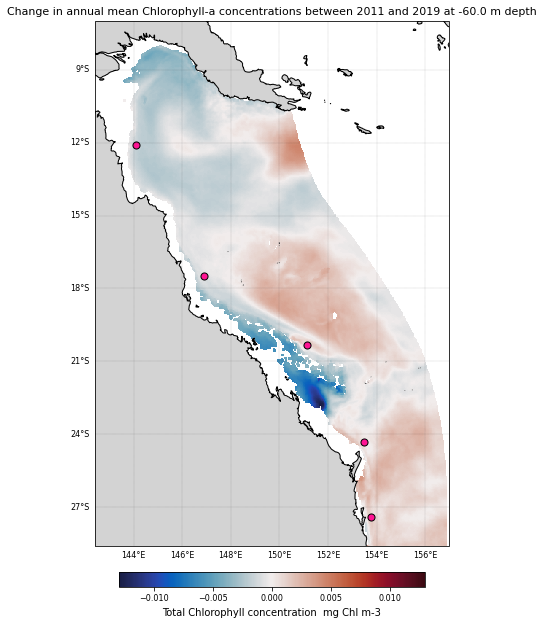

<Figure size 432x288 with 0 Axes>

In [10]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the coefficients between chlorophyll a and time index at -60m depth
cf = res.polyfit_coefficients.sel(degree=1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    
    add_colorbar=False
)


# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds.long_name+' concentration  '+ds.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Change in annual mean Chlorophyll-a concentrations between 2011 and 2019 at '+str(ds.zc.values.item(-1))+' m depth',
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Site Davies Reef
ax.scatter(locA_lon, locA_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locB_lon, locB_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locC_lon, locC_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locD_lon, locD_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locE_lon, locE_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
plt.tight_layout()
# plt.savefig('chl-60.png',dpi=300, bbox_inches='tight')
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

# Temperature change

We will do the same thing as above, with the sea surface temperature(-0.5m) and the temperature at -60m.

To be more efficient to get the file, we use the yearly mean data here.

In [11]:
# For the bio dataset
base_url = 'https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/annual-annual/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_annual-annual-'

year_st = 2011    # Year
year_ed = 2018    # Year

# Based on the server the file naming convention 
biofiles = [f"{base_url}{year}.nc" for year in range(year_st, year_ed+1) ]

ds_bio = xr.open_mfdataset(biofiles,use_cftime= True)
ds_bio

<xarray.Dataset>
Dimensions:          (time: 8, k: 17, latitude: 723, longitude: 491)
Coordinates:
    zc               (k) float64 dask.array<chunksize=(17,), meta=np.ndarray>
  * time             (time) object 2010-12-31 14:00:00 ... 2017-12-31 14:00:00
  * latitude         (latitude) float64 -28.7 -28.67 -28.64 ... -7.066 -7.036
  * longitude        (longitude) float64 142.2 142.2 142.2 ... 156.8 156.8 156.9
Dimensions without coordinates: k
Data variables: (12/108)
    TOTAL_NITROGEN   (time, k, latitude, longitude) float32 dask.array<chunksize=(1, 17, 723, 491), meta=np.ndarray>
    alk              (time, k, latitude, longitude) float32 dask.array<chunksize=(1, 17, 723, 491), meta=np.ndarray>
    BOD              (time, k, latitude, longitude) float32 dask.array<chunksize=(1, 17, 723, 491), meta=np.ndarray>
    Chl_a_sum        (time, k, latitude, longitude) float32 dask.array<chunksize=(1, 17, 723, 491), meta=np.ndarray>
    CO32             (time, k, latitude, longitude) float32 dask.array<chunksize=(1, 17, 723, 491), meta=np.ndarray>
    DetBL_N          (time, k, latitude, longitude) float32 dask.array<chunksize=(1, 17, 723, 491), meta=np.ndarray>
    ...               ...
    SGH_N            (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
    SGH_N_pr         (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
    SGHROOT_N        (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
    SGROOT_N         (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
    TSSM             (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
    Zenith2D         (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
Attributes: (12/20)
    Conventions:                     CF-1.0
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    RunID:                           2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2021-09-08T03:18:50+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__GBR4_H2p0...
    ...                              ...
    paramfile:                       /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_C...
    paramhead:                       eReefs 4 km grid. SOURCE Catchments with...
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 BioGeoChemical 3....
    DODS_EXTRA.Unlimited_Dimension:  time

## Temperature variation at -60m

In [12]:
#select the depth
ds_dpth = ds_bio.sel(k=5)

ds_bio_t= ds_dpth[['temp']]
ds_bio_t

<xarray.Dataset>
Dimensions:    (time: 8, latitude: 723, longitude: 491)
Coordinates:
    zc         float64 dask.array<chunksize=(), meta=np.ndarray>
  * time       (time) object 2010-12-31 14:00:00 ... 2017-12-31 14:00:00
  * latitude   (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude  (longitude) float64 142.2 142.2 142.2 142.3 ... 156.8 156.8 156.9
Data variables:
    temp       (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
Attributes: (12/20)
    Conventions:                     CF-1.0
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    RunID:                           2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2021-09-08T03:18:50+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__GBR4_H2p0...
    ...                              ...
    paramfile:                       /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_C...
    paramhead:                       eReefs 4 km grid. SOURCE Catchments with...
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 BioGeoChemical 3....
    DODS_EXTRA.Unlimited_Dimension:  time

In [13]:
ds = ds_bio_t.temp

In [14]:
#replace with time index
timeIndex = [i+1 for i in range(len(ds.time))]
newDataArray = ds.assign_coords(time=timeIndex)
newDataArray


<xarray.DataArray 'temp' (time: 8, latitude: 723, longitude: 491)>
dask.array<getitem, shape=(8, 723, 491), dtype=float32, chunksize=(1, 723, 491), chunktype=numpy.ndarray>
Coordinates:
    zc         float64 dask.array<chunksize=(), meta=np.ndarray>
  * time       (time) int32 1 2 3 4 5 6 7 8
  * latitude   (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude  (longitude) float64 142.2 142.2 142.2 142.3 ... 156.8 156.8 156.9
Attributes:
    short_name:   temp
    aggregation:  Monthly
    units:        degrees C
    long_name:    Temperature
    _ChunkSizes:  [  1   1 133 491]

In [15]:
#use the polyfit function to do linear fitting
rest = newDataArray.polyfit(dim='time',deg=1)
# rest

## Calculate tht total temperature change -60m

In [16]:
dm = rest.polyfit_coefficients.sel(degree=1).to_dataframe()
dm.mean()

degree                  1.000000
polyfit_coefficients    0.017894
dtype: float64

In [17]:
db = rest.polyfit_coefficients.sel(degree=0).to_dataframe()
db.mean()

degree                   0.000000
polyfit_coefficients    25.236108
dtype: float64

In [18]:
m=0.017894
b=25.236108
perc = m*8/b*100
print(f'temperature % change -60m = {round(perc,4)}%')

temperature % change -60m = 0.5673%


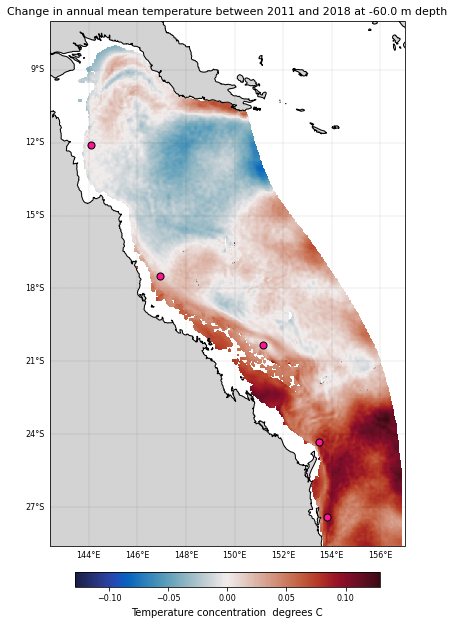

<Figure size 432x288 with 0 Axes>

In [19]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = rest.polyfit_coefficients.sel(degree=1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    
    add_colorbar=False
)


# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds.long_name+' concentration  '+ds.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Change in annual mean temperature between 2011 and 2018 at '+str(ds.zc.values.item(-1))+' m depth',
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Site Davies Reef
ax.scatter(locA_lon, locA_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locB_lon, locB_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locC_lon, locC_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locD_lon, locD_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locE_lon, locE_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()
# plt.savefig('temp-60.png',dpi=300, bbox_inches='tight')
fig.clear()
plt.close(fig)
plt.clf()

## Temperature variation at -0.5m

In [20]:
#select the depth
ds_dpth = ds_bio.sel(k=-1)

ds_bio_t0= ds_dpth[['temp']]
ds_bio_t0

<xarray.Dataset>
Dimensions:    (time: 8, latitude: 723, longitude: 491)
Coordinates:
    zc         float64 dask.array<chunksize=(), meta=np.ndarray>
  * time       (time) object 2010-12-31 14:00:00 ... 2017-12-31 14:00:00
  * latitude   (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude  (longitude) float64 142.2 142.2 142.2 142.3 ... 156.8 156.8 156.9
Data variables:
    temp       (time, latitude, longitude) float32 dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
Attributes: (12/20)
    Conventions:                     CF-1.0
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    RunID:                           2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2021-09-08T03:18:50+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__GBR4_H2p0...
    ...                              ...
    paramfile:                       /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_C...
    paramhead:                       eReefs 4 km grid. SOURCE Catchments with...
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 BioGeoChemical 3....
    DODS_EXTRA.Unlimited_Dimension:  time

In [21]:
ds = ds_bio_t0.temp

In [22]:
timeIndex = [i+1 for i in range(len(ds.time))]

newDataArray = ds.assign_coords(time=timeIndex)
# newDataArray
rest0 = newDataArray.polyfit(dim='time',deg=1)
# rest0

## Calculate the total temperature change -0.5m

In [23]:
dm = rest0.polyfit_coefficients.sel(degree=1).to_dataframe()
dm.mean()

degree                  1.000000
polyfit_coefficients    0.016508
dtype: float64

In [24]:
db = rest0.polyfit_coefficients.sel(degree=0).to_dataframe()
db.mean()

degree                   0.000000
polyfit_coefficients    26.542261
dtype: float64

In [25]:
m=0.016508
b=26.542261
perc = m*8/b*100
print(f'temperature % change -0.5m = {round(perc,4)}%')

temperature % change -0.5m = 0.4976%


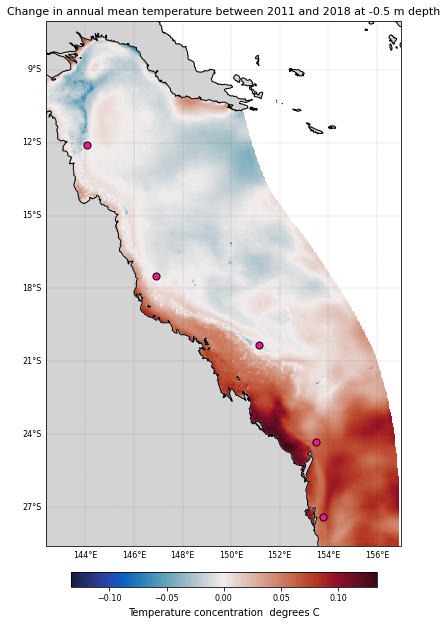

<Figure size 432x288 with 0 Axes>

In [26]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = rest0.polyfit_coefficients.sel(degree=1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    
    add_colorbar=False
)


# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds.long_name+' concentration  '+ds.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Change in annual mean temperature between 2011 and 2018 at '+str(ds.zc.values.item(-1))+' m depth',
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Site Davies Reef
ax.scatter(locA_lon, locA_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locB_lon, locB_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locC_lon, locC_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locD_lon, locD_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locE_lon, locE_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()
# plt.savefig('temp-0.5.png',dpi=300, bbox_inches='tight')
fig.clear()
plt.close(fig)
plt.clf()